In [1]:
import pandas as pd
import urllib.request


data = pd.read_csv('../../../twitter/tweetdata/2019_up1_tweet.csv', error_bad_lines=False)
data = data.append(pd.read_csv('../../../twitter/tweetdata/2019_up1_tweet(e).csv', error_bad_lines=False))




In [2]:
text = data[['text']].astype(str)
text['text'] = text.apply(lambda row: row['text'].replace("/"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("-"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("—"," "), axis=1)
#text['main article'] = text.apply(lambda row: row['main article'].replace("",""), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("*"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("…"," "), axis=1)
text['text'] = text.apply(lambda row: row['text'].replace("\\"," "), axis=1)



In [3]:
import nltk
text['text'] = text.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [4]:
# 소문자 적용 , - 문자 삭제
text['text'] = text['text'].apply(lambda x : [word.lower().replace("-","") for word in x])
# 공백문자 삭제
text['text'] = text['text'].apply(lambda x : [word for word in x if word])

In [5]:
from nltk.tag import pos_tag

text['pos tag'] = text.apply(lambda row: pos_tag(row['text']), axis=1)

In [6]:
# 불용어 품사 제거
text['text'] = text['pos tag'].apply(lambda x: [word[0] for word in x if word[1] not in ('CC','CD','DT','EX','IN','LS','MD','PRP','PRP$','RB','TO','UH','WDT','WP','WP$','WRB')])


In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
text['text'] = text['text'].apply(lambda x: [word for word in x if word not in (stop)])

In [8]:
import csv
stopword_list =[]
f = open('../../../stopword/stop_en.txt', 'r')
reader = csv.reader(f)
for row in reader:
    #print(row[0])
    stopword_list.append(row[0])
    #pass
f.close()

text['text'] = text['text'].apply(lambda x: [word for word in x if word not in stopword_list])

In [9]:
import re
pattern=re.compile(r'\.')
print(pattern.search('abc.de'))

text['text'] = text['text'].apply(lambda x: [word for word in x if pattern.search(word)== None])

<re.Match object; span=(3, 4), match='.'>


In [10]:
number_pattern=re.compile(r'[0-9]\,[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if number_pattern.search(word)== None])

In [11]:
native_number_pattern=re.compile(r'[0-9]')
text['text'] = text['text'].apply(lambda x: [word for word in x if native_number_pattern.search(word)== None])

In [12]:
star_pattern=re.compile(r'[a-z0-9*]\*[a-z0-9*]')
text['text'] = text['text'].apply(lambda x: [word for word in x if star_pattern.search(word)== None])

In [13]:
from nltk.stem import WordNetLemmatizer
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x]) # 동사 
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='a') for word in x]) # 형용사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='n') for word in x]) # 명사
text['text'] = text['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='r') for word in x]) # 부사
#print(text)

In [14]:
tokenized_doc = text['text'].apply(lambda x: [word for word in x if len(word) > 3])
#print(tokenized_doc)

In [15]:
article_contents = tokenized_doc.values.tolist()

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

In [17]:
tokenized_doc_tfidf = tokenized_doc.apply(lambda x : ' '.join(x))

In [18]:
article_contents_tfidf = tokenized_doc_tfidf.values.tolist()

In [19]:
vectorizer = TfidfVectorizer()
sp_matrix = vectorizer.fit_transform([ " ".join(article_contents_tfidf) ])

In [20]:
word2id = defaultdict(lambda: 0)

In [21]:
for idx, feature in enumerate(vectorizer.get_feature_names()):
    word2id[feature] = idx

In [22]:
tf_idf_result = []
token_list = []
for i, sent in enumerate([" ".join(article_contents_tfidf)]):
    for token in sent.split() :
        if token not in token_list :
            temp=[]
            temp.append(token)
            temp.append(sp_matrix[i, word2id[token]])
            token_list.append(token)
            tf_idf_result.append(temp)

In [23]:
len(tf_idf_result)

5209

In [24]:
tf_idf_value =[]
for tf_idf_element in tf_idf_result :
    tf_idf_value.append(tf_idf_element[1])
print(len(tf_idf_value))  ## tf-idf 값을 배열에 담음

5209


In [25]:
sentences = article_contents

In [26]:
from gensim.models import Word2Vec

In [27]:
model = Word2Vec(sentences, min_count=1)

In [28]:
len(model.wv.vocab)

5209

In [29]:
X = model[model.wv.vocab]

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [30]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
#kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.euclidean_distance, repeats=25)
#euclidean_distance
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
#print(X)
#print(assigned_clusters)

In [31]:
import pandas as pd
import numpy as np
temp_heder = ['raw_data','word','cluster','centroid','distance','tfidf','score','closer#']
temp_cluster_result = pd.DataFrame(columns=temp_heder)

In [32]:
temp_cluster_result['word'] = list(model.wv.vocab)

In [33]:
temp_cluster_result['cluster'] = assigned_clusters

In [34]:
temp_cluster_result['raw_data'] = X.tolist()

In [35]:
#temp_cluster_result['raw_data']
temp_cluster_result['centroid'] = temp_cluster_result['cluster'].apply(lambda x : kclusterer.means()[x])

In [36]:
from sklearn.metrics import pairwise_distances

In [37]:
cosine_centroid_list = []
for cosine_centroid in temp_cluster_result['centroid'] :
    cosine_centroid_list.append(cosine_centroid.tolist())

In [38]:
len(cosine_centroid_list)

5209

In [39]:
temp_distance = pairwise_distances(X,cosine_centroid_list, metric='cosine')

In [40]:
sum(temp_distance[3])

159.1432099419683

In [41]:
import scipy.spatial.distance as dist

In [42]:
dist.cosine(X[0],cosine_centroid_list[0])

5.257543382874985e-05

In [43]:
dist.euclidean(X[0],cosine_centroid_list[0])

2.7854552850315484

In [44]:
temp_cluster_result['distance'] = temp_cluster_result.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [45]:
temp_cluster_result['tfidf'] = tf_idf_value
temp_cluster_result['score'] = temp_cluster_result.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result

In [46]:
temp_cluster_result[temp_cluster_result['cluster']==0].sort_values(by=['score']).head(30)  # 비즈

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
2145,"[0.003015215042978525, -0.004130692221224308, ...",rapacious,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.128547,0.000311,1.128235,NaN
505,"[0.0007995705236680806, -0.006903094705194235,...",switzerland,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.153381,0.000622,1.152758,NaN
4766,"[0.000921105092857033, -0.0060485475696623325,...",outstanding,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.166306,0.000311,1.165995,NaN
2295,"[0.0013575551565736532, -0.0010570833692327142...",bittorrent,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.220564,0.000933,1.219631,NaN
1320,"[-0.0013296841643750668, 0.0004234544758219272...",stamp,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.223555,0.000933,1.222622,NaN
2787,"[0.002287194598466158, -4.309856740292162e-05,...",critique,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.245315,0.000311,1.245004,NaN
563,"[-0.003575797425583005, 0.00031911913538351655...",derivation,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.270506,0.000311,1.270194,NaN
2108,"[0.005228078458458185, -0.005340372212231159, ...",rampage,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.289335,0.000311,1.289024,NaN
603,"[0.004095199052244425, -0.0007445411174558103,...",zürich,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.307425,0.000311,1.307114,NaN
2957,"[-0.003643094329163432, -0.006324189715087414,...",erlay,0,"[0.00032778553, -0.0002844193, -0.00026503898,...",0.343557,0.000622,1.342935,NaN


In [47]:
temp_cluster_result[temp_cluster_result['cluster']==1].sort_values(by=['score']).head(30)  # 거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
852,"[-0.00697141420096159, 0.008927595801651478, 0...",banner,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.028334,0.000622,1.027712,NaN
1290,"[-0.0072249723598361015, 0.005715478677302599,...",chairman,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.032300,0.000933,1.031366,NaN
3467,"[-0.007444579154253006, 0.003813214134424925, ...",avenue,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.055970,0.000311,1.055659,NaN
4027,"[-0.006325810682028532, -5.504865839611739e-05...",optimize,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.071174,0.000622,1.070552,NaN
4128,"[-0.001262428006157279, 0.0007622195989824831,...",travel,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.072814,0.000622,1.072192,NaN
5136,"[-0.004503594245761633, 0.00047091703163459897...",shard,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.074530,0.000311,1.074218,NaN
2417,"[-0.0033769470173865557, 0.004463411867618561,...",mount,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.078901,0.000311,1.078590,NaN
1552,"[-0.004269822034984827, 0.0029751998372375965,...",whoop,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.081880,0.000311,1.081569,NaN
1728,"[-0.000249738892307505, 0.005591620225459337, ...",incompetence,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.084763,0.000622,1.084141,NaN
3148,"[-0.006685665342956781, 0.0026171039789915085,...",elonmusk,1,"[-0.001479141, 0.0018139096, 0.0012012533, -0....",0.089529,0.000311,1.089218,NaN


In [48]:
temp_cluster_result[temp_cluster_result['cluster']==2].sort_values(by=['score']).head(40)   # 협업

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
373,"[-0.01035354658961296, 0.006333452649414539, 0...",suspect,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.011818,0.001244,1.010573,NaN
220,"[-0.0066634430550038815, 0.011441758833825588,...",topology,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.017780,0.000933,1.016847,NaN
1124,"[-0.0035505930427461863, 0.005749150644987822,...",swing,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.020077,0.000933,1.019144,NaN
3890,"[0.00031924486393108964, 0.00538736954331398, ...",tpay,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.020158,0.000933,1.019225,NaN
4019,"[-0.004514590837061405, 0.004005249124020338, ...",database,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.022018,0.000933,1.021085,NaN
2626,"[-0.008304997347295284, 0.0045849913731217384,...",monument,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.024057,0.000933,1.023124,NaN
1484,"[-0.004806643817573786, 0.004353419411927462, ...",hesterpeirce,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.023910,0.000622,1.023287,NaN
388,"[-0.002449405612424016, 0.0055955336429178715,...",subtle,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.024721,0.000933,1.023788,NaN
3937,"[-0.005945371929556131, 0.0034469887614250183,...",understandingbitcoin,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.026284,0.001244,1.025040,NaN
2117,"[0.00010181455581914634, 0.010817187838256359,...",rt_com,2,"[-0.0020980677, 0.002233091, 0.00146177, -0.00...",0.026301,0.000622,1.025679,NaN


In [49]:
temp_cluster_result[temp_cluster_result['cluster']==3].sort_values(by=['score']).head(20)  # 거래소

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[-0.23782046139240265, 0.4670693576335907, 0.2...",bitcoin,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000014,0.928384,0.071630,NaN
81,"[-0.1436149626970291, 0.2839833199977875, 0.14...",http,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000023,0.112937,0.887086,NaN
182,"[-0.11722573637962341, 0.21707013249397278, 0....",market,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000043,0.089603,0.910440,NaN
133,"[-0.1128629669547081, 0.22297073900699615, 0.1...",gold,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000037,0.077780,0.922257,NaN
181,"[-0.11587588489055634, 0.22720979154109955, 0....",crypto,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000034,0.077158,0.922876,NaN
37,"[-0.10721047967672348, 0.21236228942871094, 0....",ethereum,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000052,0.076225,0.923827,NaN
49,"[-0.11366389691829681, 0.2255372703075409, 0.1...",people,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000037,0.063157,0.936879,NaN
320,"[-0.11670831590890884, 0.23349978029727936, 0....",time,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000034,0.059424,0.940610,NaN
1997,"[-0.07807496190071106, 0.1547333300113678, 0.0...",keiser,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000085,0.059424,0.940661,NaN
0,"[-0.10006863623857498, 0.20086032152175903, 0....",price,3,"[-0.008963019, 0.017708067, 0.009219769, -0.03...",0.000053,0.058491,0.941562,NaN


In [50]:
y_km = temp_cluster_result['cluster'].values

In [51]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

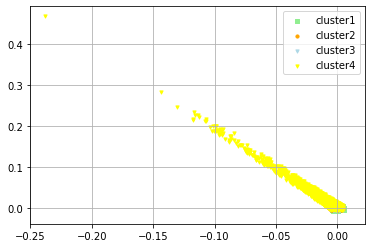

In [52]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[y_km==1,0],X[y_km==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[y_km==2,0],X[y_km==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[y_km==3,0],X[y_km==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [53]:
len(temp_cluster_result[temp_cluster_result['cluster']==0]) # 인플

70

In [54]:
len(temp_cluster_result[temp_cluster_result['cluster']==1]) # 비즈 

329

In [55]:
len(temp_cluster_result[temp_cluster_result['cluster']==2]) # 협업

753

In [56]:
len(temp_cluster_result[temp_cluster_result['cluster']==3]) # 거래소

4057

In [57]:
# X[:,1]
from sklearn.cluster import AgglomerativeClustering
import numpy as np

agg = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="cosine")

assign = agg.fit_predict(X)
# assign = agg.fit(X)

In [58]:
len(assign)

5209

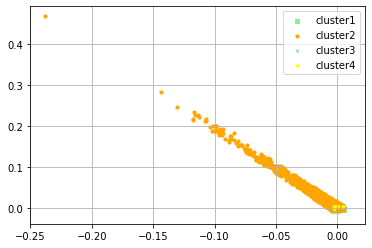

In [59]:
plt.scatter(X[assign==0,0],X[assign==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign==1,0],X[assign==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign==2,0],X[assign==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign==3,0],X[assign==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [60]:
assign

array([1, 1, 1, ..., 1, 1, 1])

In [61]:
from scipy.cluster.hierarchy import dendrogram

In [62]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

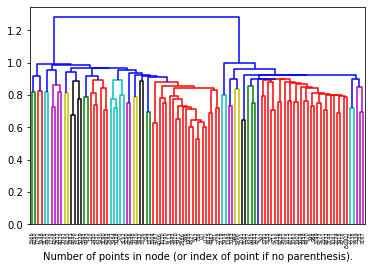

In [63]:

model1 = AgglomerativeClustering(linkage ="average", affinity="cosine", distance_threshold=0, n_clusters=None)

model1.fit(X)

plot_dendrogram(model1, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [64]:
temp_cluster_result0 = pd.DataFrame(columns=temp_heder)

In [65]:
temp_cluster_result0['word'] = list(model.wv.vocab)

In [66]:
temp_cluster_result0['cluster'] = assign

In [67]:
temp_cluster_result0['raw_data'] = X.tolist()

In [68]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid()
clf.fit(X, assign)

temp_cluster_result0['centroid'] = temp_cluster_result0['cluster'].apply(lambda x : clf.centroids_[x])

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [69]:
cosine_centroid_list0 = []
for cosine_centroid in temp_cluster_result0['centroid'] :
    cosine_centroid_list0.append(cosine_centroid.tolist())

In [70]:
temp_distance0 = pairwise_distances(X,cosine_centroid_list0, metric='cosine')

In [71]:
temp_cluster_result0['distance'] = temp_cluster_result0.apply(lambda x : dist.cosine(x.raw_data,x.centroid),axis=1)

In [72]:
temp_cluster_result0['tfidf'] = tf_idf_value
temp_cluster_result0['score'] = temp_cluster_result0.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [73]:
temp_cluster_result0[temp_cluster_result0['cluster']==0].sort_values(by=['score']).head(20)  # 제도개선, 비즈니스

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
2145,"[0.003015215042978525, -0.004130692221224308, ...",rapacious,0,"[0.0004422177153173834, -0.0002805742551572621...",0.126495,0.000311,1.126184,NaN
505,"[0.0007995705236680806, -0.006903094705194235,...",switzerland,0,"[0.0004422177153173834, -0.0002805742551572621...",0.156621,0.000622,1.155999,NaN
4766,"[0.000921105092857033, -0.0060485475696623325,...",outstanding,0,"[0.0004422177153173834, -0.0002805742551572621...",0.169825,0.000311,1.169514,NaN
2295,"[0.0013575551565736532, -0.0010570833692327142...",bittorrent,0,"[0.0004422177153173834, -0.0002805742551572621...",0.212874,0.000933,1.211941,NaN
1320,"[-0.0013296841643750668, 0.0004234544758219272...",stamp,0,"[0.0004422177153173834, -0.0002805742551572621...",0.225201,0.000933,1.224267,NaN
2787,"[0.002287194598466158, -4.309856740292162e-05,...",critique,0,"[0.0004422177153173834, -0.0002805742551572621...",0.263287,0.000311,1.262976,NaN
563,"[-0.003575797425583005, 0.00031911913538351655...",derivation,0,"[0.0004422177153173834, -0.0002805742551572621...",0.274938,0.000311,1.274627,NaN
2108,"[0.005228078458458185, -0.005340372212231159, ...",rampage,0,"[0.0004422177153173834, -0.0002805742551572621...",0.299765,0.000311,1.299454,NaN
603,"[0.004095199052244425, -0.0007445411174558103,...",zürich,0,"[0.0004422177153173834, -0.0002805742551572621...",0.308499,0.000311,1.308188,NaN
2062,"[0.0014185805339366198, 0.003335453337058425, ...",bitchrist,0,"[0.0004422177153173834, -0.0002805742551572621...",0.345997,0.000311,1.345686,NaN


In [74]:
temp_cluster_result0[temp_cluster_result0['cluster']==1].sort_values(by=['score']).head(20)  # 투자, 거래 , 비즈 

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[-0.23782046139240265, 0.4670693576335907, 0.2...",bitcoin,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000011,0.928384,0.071627,NaN
81,"[-0.1436149626970291, 0.2839833199977875, 0.14...",http,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000026,0.112937,0.887089,NaN
182,"[-0.11722573637962341, 0.21707013249397278, 0....",market,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000041,0.089603,0.910439,NaN
133,"[-0.1128629669547081, 0.22297073900699615, 0.1...",gold,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000035,0.077780,0.922255,NaN
181,"[-0.11587588489055634, 0.22720979154109955, 0....",crypto,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000035,0.077158,0.922877,NaN
37,"[-0.10721047967672348, 0.21236228942871094, 0....",ethereum,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000050,0.076225,0.923825,NaN
49,"[-0.11366389691829681, 0.2255372703075409, 0.1...",people,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000039,0.063157,0.936882,NaN
320,"[-0.11670831590890884, 0.23349978029727936, 0....",time,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000037,0.059424,0.940613,NaN
1997,"[-0.07807496190071106, 0.1547333300113678, 0.0...",keiser,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000082,0.059424,0.940658,NaN
0,"[-0.10006863623857498, 0.20086032152175903, 0....",price,1,"[-0.007492897100746632, 0.014449824579060078, ...",0.000050,0.058491,0.941560,NaN


In [75]:
temp_cluster_result0[temp_cluster_result0['cluster']==2].sort_values(by=['score']).head(20)  # 비즈

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
2119,"[-0.0029551393818110228, 0.0009279252262786031...",cashapp,2,"[-0.00279719615355134, 0.0017487930599600077, ...",0.221956,0.000622,1.221334,NaN
3914,"[-0.002639253158122301, 0.0025696607772260904,...",bargan,2,"[-0.00279719615355134, 0.0017487930599600077, ...",0.229779,0.000311,1.229468,NaN


In [76]:
temp_cluster_result0[temp_cluster_result0['cluster']==3].sort_values(by=['score']).head(20)  #  기타

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
3948,"[-0.0019436655566096306, 0.0026906484272331, -...",february,3,"[0.0001698050764389336, 0.0016073717270046473,...",0.376461,0.000311,1.376149,NaN
3566,"[0.00482885492965579, 0.003059398615732789, -0...",etfcom,3,"[0.0001698050764389336, 0.0016073717270046473,...",0.412045,0.000311,1.411734,NaN
1791,"[0.0003769526374526322, 0.0023845327086746693,...",yankee,3,"[0.0001698050764389336, 0.0016073717270046473,...",0.435049,0.000311,1.434738,NaN
4250,"[-0.0025829218793660402, -0.001705093542113900...",yawn,3,"[0.0001698050764389336, 0.0016073717270046473,...",0.466470,0.000311,1.466159,NaN


In [77]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==0]) # 제도개선, 비즈 

71

In [78]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==1]) # 투자, 거래 , 비즈

5132

In [79]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==2]) # 비즈

2

In [84]:
len(temp_cluster_result0[temp_cluster_result0['cluster']==3]) # 기타

4

In [85]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(X, assign, metric='cosine')

In [86]:
silhouette_score

0.77904344

In [87]:
"""
temp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter
temp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈
temp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈
temp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전
temp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈
"""

"\ntemp_cluster_result['category'] = 1 # 1 영문뉴스, 2 국문뉴스 , 3 twitter\ntemp_cluster_result.loc[temp_cluster_result['cluster']==0,'label'] = 7 # 비즈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==1,'label'] = 12 #  가격, 거래소, 돈\ntemp_cluster_result.loc[temp_cluster_result['cluster']==2,'label'] = 9 # 기술발전\ntemp_cluster_result.loc[temp_cluster_result['cluster']==3,'label'] = 7 # 비즈\n"

In [88]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

KMeans(n_clusters=4)

In [89]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [90]:
kmeans.inertia_

97.32461547851562

In [91]:
print ("Cluster id labels for inputted data")
print (labels)

Cluster id labels for inputted data
[2 1 1 ... 0 0 0]


In [92]:
cluster_values= list(model.wv.vocab)

In [93]:
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-97.32461547851562


In [94]:
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

In [95]:
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.7300745


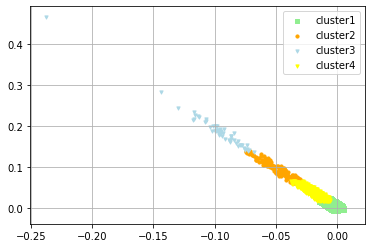

In [96]:
kmeans_label = kmeans.labels_

plt.scatter(X[kmeans_label==0,0],X[kmeans_label==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[kmeans_label==1,0],X[kmeans_label==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[kmeans_label==2,0],X[kmeans_label==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[kmeans_label==3,0],X[kmeans_label==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[kmeans_label==4,0],X[kmeans_label==4,1],c='red',marker='v',s=10 , label='cluster5')

plt.legend()
plt.grid(True)
plt.show()

In [97]:
temp_cluster_result1 = pd.DataFrame(columns=temp_heder)
temp_cluster_result1['word'] = list(model.wv.vocab)
temp_cluster_result1['cluster'] = kmeans_label

In [98]:
#temp_cluster_result1[temp_cluster_result1['cluster']==0].head(30) #시도 및 혼돈  # 혼란 부정적 
temp_cluster_result1['raw_data'] = X.tolist()

In [99]:
temp_cluster_result1['centroid'] = temp_cluster_result1['cluster'].apply(lambda x : centroids[x])

In [100]:
euclidean_centroid_list = []
for euclidean_centroid in temp_cluster_result1['centroid'] :
    euclidean_centroid_list.append(euclidean_centroid.tolist())

In [101]:
temp_distance1 = pairwise_distances(X,euclidean_centroid_list, metric='euclidean')

In [102]:
import scipy.spatial.distance as dist

In [103]:
temp_cluster_result1['distance'] = temp_cluster_result1.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [104]:
temp_cluster_result1['tfidf'] = tf_idf_value
temp_cluster_result1['score'] = temp_cluster_result1.apply(lambda x : x.distance + (1- x.tfidf),axis=1)
#temp_cluster_result1

In [105]:
temp_cluster_result1[temp_cluster_result1['cluster']==0].sort_values('score',ascending=False).nsmallest(30,'score') # 부정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
2818,"[-0.005450451746582985, 0.0071804821491241455,...",'frantic,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.026036,0.008089,1.017947,NaN
3817,"[-0.005509861279278994, 0.004069957882165909, ...",'grasshopper,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.028116,0.008089,1.020026,NaN
2288,"[-0.00134146714117378, 0.00875062681734562, 0....",'unmitigated,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.028677,0.008089,1.020588,NaN
2761,"[-0.007433027029037476, 0.006162366364151239, ...",mishgea⁩,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.029526,0.008089,1.021437,NaN
894,"[-0.004263326060026884, 0.00271606189198792, 0...",soc_src=social,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.029676,0.008089,1.021587,NaN
2129,"[-0.0014419159851968288, 0.0010663480497896671...",'satoshi,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.030445,0.008089,1.022356,NaN
2308,"[-0.003843729617074132, 0.00871203187853098, -...",rs=pn,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.030725,0.008089,1.022635,NaN
2848,"[-0.0027610608376562595, 0.0014856037450954318...",ตัวจริงเพื่อล้อเลียน,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.031175,0.008089,1.023086,NaN
1318,"[-0.003916270099580288, 0.005914167035371065, ...",╱╱╭╮╲╲,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.031534,0.008089,1.023445,NaN
2306,"[-0.002398734213784337, 0.0004873572615906596,...",d=pall,0,"[-0.0030580633, 0.0057862606, 0.0030763266, -0...",0.031763,0.008089,1.023673,NaN


In [106]:
temp_cluster_result1[temp_cluster_result1['cluster']==1].sort_values('score',ascending=False).nsmallest(40,'score') # 긍정

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
518,"[-0.050100177526474, 0.08630454540252686, 0.05...",libra,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.029947,0.014623,1.015324,NaN
94,"[-0.043101128190755844, 0.09296347945928574, 0...",listen,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.032218,0.014623,1.017595,NaN
333,"[-0.043163053691387177, 0.09571072459220886, 0...",right,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.030698,0.011511,1.019187,NaN
810,"[-0.04977825656533241, 0.08771524578332901, 0....",hold,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.034694,0.014623,1.020072,NaN
497,"[-0.04666731134057045, 0.09227314591407776, 0....",claim,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.030070,0.009645,1.020425,NaN
102,"[-0.050228167325258255, 0.08577077835798264, 0...",store,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.032590,0.012134,1.020456,NaN
339,"[-0.043629322201013565, 0.09149011224508286, 0...",find,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.032433,0.011200,1.021232,NaN
635,"[-0.05033258721232414, 0.08808299154043198, 0....",lead,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.030324,0.009022,1.021302,NaN
746,"[-0.046857189387083054, 0.08751092851161957, 0...",cryptocurrency,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.032256,0.010578,1.021678,NaN
1446,"[-0.05135171487927437, 0.09542035311460495, 0....",small,1,"[-0.046851773, 0.09120728, 0.047405068, -0.201...",0.032489,0.009956,1.022533,NaN


In [107]:
temp_cluster_result1[temp_cluster_result1['cluster']==2].sort_values('score',ascending=False).nsmallest(30,'score')  # 제도,한계

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
21,"[-0.10013958066701889, 0.18732541799545288, 0....",network,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.036329,0.028312,1.008017,NaN
24,"[-0.09559717774391174, 0.19238057732582092, 0....",take,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.042847,0.032045,1.010801,NaN
34,"[-0.10252068191766739, 0.18845853209495544, 0....",work,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.045543,0.034534,1.011008,NaN
192,"[-0.09277757257223129, 0.19289281964302063, 0....",look,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.046775,0.033912,1.012863,NaN
389,"[-0.09880923479795456, 0.19010284543037415, 0....",risk,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.038026,0.023023,1.015003,NaN
330,"[-0.09897956252098083, 0.18845818936824799, 0....",need,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.051009,0.028001,1.023008,NaN
569,"[-0.0951806902885437, 0.18735402822494507, 0.1...",talk,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.066063,0.037957,1.028106,NaN
0,"[-0.10006863623857498, 0.20086032152175903, 0....",price,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.091808,0.058491,1.033318,NaN
101,"[-0.09479101002216339, 0.18446999788284302, 0....",come,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.066405,0.030801,1.035604,NaN
56,"[-0.09749455749988556, 0.18457701802253723, 0....",want,2,"[-0.09757284, 0.19018482, 0.09937835, -0.42247...",0.074643,0.031734,1.042909,NaN


In [108]:
temp_cluster_result1[temp_cluster_result1['cluster']==3].sort_values('score',ascending=False).nsmallest(30,'score') #  기타

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4534,"[-0.022785907611250877, 0.037084098905324936, ...",_cryptoiq,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.027604,0.008089,1.019515,NaN
1174,"[-0.015456601977348328, 0.03397376462817192, 0...",retail,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.025492,0.003422,1.022069,NaN
1331,"[-0.01914971135556698, 0.03639814257621765, 0....",period,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.026430,0.004356,1.022074,NaN
1685,"[-0.0213796216994524, 0.030479544773697853, 0....",institutional,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.028354,0.004356,1.023999,NaN
1515,"[-0.021295158192515373, 0.03174736350774765, 0...",life,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.028598,0.003733,1.024864,NaN
2193,"[-0.01644996926188469, 0.03430382162332535, 0....",wright,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.029353,0.004045,1.025308,NaN
2920,"[-0.014844009652733803, 0.036424729973077774, ...",comment,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.029085,0.003733,1.025352,NaN
1900,"[-0.015589236281812191, 0.0366898849606514, 0....",status,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.030405,0.004978,1.025427,NaN
2161,"[-0.014362810179591179, 0.0370907261967659, 0....",third,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.028519,0.002800,1.025719,NaN
46,"[-0.016080521047115326, 0.03939034417271614, 0...",begin,3,"[-0.018103065, 0.03532243, 0.018423384, -0.078...",0.029911,0.004045,1.025867,NaN


In [109]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==0]) # 부정

4339

In [110]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==1]) # 긍정

183

In [111]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==2]) # 제도,한계

52

In [112]:
len(temp_cluster_result1[temp_cluster_result1['cluster']==3]) # 기타

635

In [113]:
agg1 = AgglomerativeClustering(n_clusters=4, linkage ="average", affinity="euclidean")

assign1 = agg1.fit_predict(X)

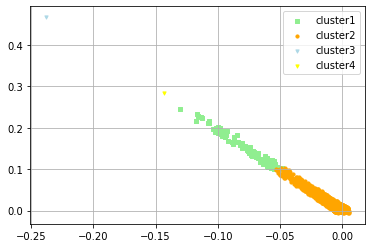

In [114]:
plt.scatter(X[assign1==0,0],X[assign1==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign1==1,0],X[assign1==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign1==2,0],X[assign1==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign1==3,0],X[assign1==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [115]:
temp_cluster_result2 = pd.DataFrame(columns=temp_heder)
temp_cluster_result2['word'] = list(model.wv.vocab)
temp_cluster_result2['cluster'] = assign1
temp_cluster_result2['raw_data'] = X.tolist()
clf1 = NearestCentroid()
clf1.fit(X, assign1)

NearestCentroid()

In [116]:
temp_cluster_result2['centroid'] = temp_cluster_result2['cluster'].apply(lambda x : clf1.centroids_[x])

In [117]:
euclidean_centroid_list2 = []
for euclidean_centroid in temp_cluster_result2['centroid'] :
    euclidean_centroid_list2.append(euclidean_centroid.tolist())

In [118]:

temp_distance2 = pairwise_distances(X,euclidean_centroid_list2, metric='euclidean')

In [119]:
temp_cluster_result2['distance'] = temp_cluster_result2.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

In [120]:
temp_cluster_result2['tfidf'] = tf_idf_value
temp_cluster_result2['score'] = temp_cluster_result2.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [121]:
temp_cluster_result2[temp_cluster_result2['cluster']==0].sort_values(by=['score']).head(20) #  비즈, 긍정, 거래

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
970,"[-0.08069706708192825, 0.15075232088565826, 0....",live,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.034281,0.021778,1.012503,NaN
1997,"[-0.07807496190071106, 0.1547333300113678, 0.0...",keiser,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.079779,0.059424,1.020355,NaN
1202,"[-0.07639292627573013, 0.1458778828382492, 0.0...",high,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.056043,0.027379,1.028664,NaN
459,"[-0.07314998656511307, 0.14061030745506287, 0....",digital,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.055211,0.022090,1.033122,NaN
1005,"[-0.07190249115228653, 0.1425674557685852, 0.0...",company,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.050998,0.016489,1.034509,NaN
494,"[-0.06779178977012634, 0.13784219324588776, 0....",world,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.075578,0.025823,1.049755,NaN
104,"[-0.07331033051013947, 0.14449220895767212, 0....",week,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.082231,0.021156,1.061075,NaN
174,"[-0.07960615307092667, 0.153712198138237, 0.07...",great,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.087396,0.022712,1.064684,NaN
219,"[-0.07556205987930298, 0.14255613088607788, 0....",point,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.092051,0.018045,1.074006,NaN
397,"[-0.07395467907190323, 0.15308061242103577, 0....",exchange,0,"[-0.07583024352788925, 0.1468491405248642, 0.0...",0.097111,0.021778,1.075333,NaN


In [122]:
temp_cluster_result2[temp_cluster_result2['cluster']==1].sort_values(by=['score']).head(20) #  암호화폐, 이슈, 기술

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
1232,"[-0.005546079948544502, 0.014649730175733566, ...",coinmine,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026389,0.001556,1.024833,NaN
1649,"[-0.0034470795653760433, 0.01597510278224945, ...",cross,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.027411,0.002489,1.024922,NaN
3723,"[-0.0037023741751909256, 0.013182388618588448,...",aibcsummit,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026118,0.000933,1.025185,NaN
3666,"[-0.009094789624214172, 0.01440855860710144, 0...",present,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.027691,0.002489,1.025203,NaN
3343,"[-0.008638306520879269, 0.014400833286345005, ...",polymath,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026462,0.000933,1.025528,NaN
2977,"[-0.010564977303147316, 0.007880954071879387, ...",github,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026777,0.001244,1.025532,NaN
447,"[-0.010961559601128101, 0.012364627793431282, ...",proponent,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026852,0.001244,1.025607,NaN
3499,"[-0.005265376530587673, 0.011913510970771313, ...",center,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026706,0.000933,1.025773,NaN
670,"[-0.007643657736480236, 0.014808357693254948, ...",trouble,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026711,0.000933,1.025778,NaN
4776,"[-0.006172654684633017, 0.011507864110171795, ...",conservative,1,"[-0.00584153737872839, 0.01125714648514986, 0....",0.026401,0.000622,1.025779,NaN


In [123]:
temp_cluster_result2[temp_cluster_result2['cluster']==2].sort_values(by=['score']).head(20) # 암호화폐

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
4,"[-0.23782046139240265, 0.4670693576335907, 0.2...",bitcoin,2,"[-0.23782046139240265, 0.4670693576335907, 0.2...",0.0,0.928384,0.071616,NaN


In [124]:
temp_cluster_result2[temp_cluster_result2['cluster']==3].sort_values(by=['score']).head(20) # 기술

,raw_data,word,cluster,centroid,distance,tfidf,score,closer#
81,"[-0.1436149626970291, 0.2839833199977875, 0.14...",http,3,"[-0.1436149626970291, 0.2839833199977875, 0.14...",0.0,0.112937,0.887063,NaN


In [125]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==0]) # 비즈 긍정 거래 

109

In [126]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==1]) # 암호화폐 이슈 기술

5098

In [127]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==2]) # 암호화폐 

1

In [128]:
len(temp_cluster_result2[temp_cluster_result2['cluster']==3]) # 기술

1

In [129]:
silhouette_score1 = metrics.silhouette_score(X, assign1, metric='euclidean')

In [130]:
silhouette_score1

0.87210923

In [ ]:
agg2 = AgglomerativeClustering(n_clusters=4, linkage ="ward", affinity="euclidean")

assign2 = agg2.fit_predict(X)

In [ ]:
plt.scatter(X[assign2==0,0],X[assign2==0,1],c='lightgreen',marker='s',s=10 , label='cluster1')
plt.scatter(X[assign2==1,0],X[assign2==1,1],c='orange',marker='o',s=10 , label='cluster2')
plt.scatter(X[assign2==2,0],X[assign2==2,1],c='lightblue',marker='v',s=10 , label='cluster3')
plt.scatter(X[assign2==3,0],X[assign2==3,1],c='yellow',marker='v',s=10 , label='cluster4')
#plt.scatter(X[y_km==4,0],X[y_km==4,1],c='red',marker='v',s=10 , label='cluster5')
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red',marker='*',s=30 , label='center cluster')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
temp_cluster_result3 = pd.DataFrame(columns=temp_heder)
temp_cluster_result3['word'] = list(model.wv.vocab)
temp_cluster_result3['cluster'] = assign2
temp_cluster_result3['raw_data'] = X.tolist()
clf2 = NearestCentroid()
clf2.fit(X, assign2)

In [ ]:
temp_cluster_result3['centroid'] = temp_cluster_result3['cluster'].apply(lambda x : clf2.centroids_[x])

In [ ]:
euclidean_centroid_list3 = []
for euclidean_centroid in temp_cluster_result3['centroid'] :
    euclidean_centroid_list3.append(euclidean_centroid.tolist())

In [ ]:
temp_distance3 = pairwise_distances(X,euclidean_centroid_list3, metric='euclidean')

In [ ]:
temp_cluster_result3['distance'] = temp_cluster_result3.apply(lambda x : dist.euclidean(x.raw_data,x.centroid),axis=1)

temp_cluster_result3['tfidf'] = tf_idf_value
temp_cluster_result3['score'] = temp_cluster_result3.apply(lambda x : x.distance + (1- x.tfidf),axis=1)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==0].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==1].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==2].sort_values(by=['score']).head(20)

In [ ]:
temp_cluster_result3[temp_cluster_result3['cluster']==3].sort_values(by=['score']).head(20)

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==0])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==1])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==2])

In [ ]:
len(temp_cluster_result3[temp_cluster_result3['cluster']==3])

In [ ]:
silhouette_score3 = metrics.silhouette_score(X, assign2, metric='euclidean')

In [ ]:
silhouette_score3

In [ ]:

"""
temp_cluster_result1['result'] = 1 # 1 상승 2 하락 3 보합
temp_cluster_result['result'] = 1
temp_cluster_result1['Silhouette'] = 0.7476496# 1 상승 2 하락 3 보합
temp_cluster_result['Silhouette'] = 0.7476496
 """

In [ ]:
#temp_cluster_result1.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_euclidean.csv")
#temp_cluster_result.to_csv("../cluster/en_news/2017_up2/en_news_2017_up2_cosine.csv")